In [21]:
from sklearn.metrics import mean_absolute_error, \
    r2_score
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import numpy as np

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [23]:
class NeuralNetwork1(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork1, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 9)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier


class FeedbackHHC:
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)

    def iqr_outliers(self, col):
        Q1 = self.data[col].quantile(0.25)
        Q3 = self.data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_threshold = Q1 - 7 * IQR
        upper_threshold = Q3 + 7 * IQR
        self.data[col] = np.where(
                    (self.data[col] < lower_threshold) | (self.data[col] > upper_threshold),
                    np.nan,
                    self.data[col]
                )
        
    def preprocess_data(self):


        self.data.drop_duplicates(inplace=True)
        self.data.drop(['Certification Date','Footnote for how often patients got better at taking their drugs correctly by mouth','Footnote for how often patients got better at walking or moving around','Footnote for how often the home health team determined whether patients received a flu shot for the current flu season','Footnote for how much Medicare spends on an episode of care at this agency, compared to '
                        'Medicare spending across all agencies nationally', 'Footnote for PPR Risk-Standardized Rate',
                        'Footnote for DTC Risk-Standardized Rate', 'Footnote for Application of Percent of Long Term '
                                                                   'Care Hospital Patients with an Admission and '
                                                                   'Discharge Functional Assessment and a Care Plan '
                                                                   'that Addresses Function', 'Footnote for Percent of '
                                                                                              'Residents Experiencing '
                                                                                              'One or More Falls with '
                                                                                              'Major Injury',
                        'Footnote for how often physician-recommended actions to address medication issues were '
                        'completely timely', 'Footnote Changes in skin integrity post-acute care: pressure '
                                             'ulcer/injury', 'Footnote for how often patients receiving home health '
                                                             'care needed urgent, unplanned care in the ER without '
                                                             'being admitted', 'Footnote for how often home health '
                                                                               'patients had to be admitted to the '
                                                                               'hospital', 'Footnote for how often '
                                                                                           'patients got better at '
                                                                                           'taking'
                                                                                           'their drugs correctly by '
                                                                                           'mouth', 'Footnote for how '
                                                                                                    'often patients\' '
                                                                                                    'breathing improved',
                        'Footnote for how often patients got better at bathing', 'Footnote for how often patients got '
                                                                                 'better at getting in and out of '
                                                                                 'bed', 'Footnote for how often '
                                                                                        'patients got better at walking'
                                                                                        'or moving around',
                        'Footnote for how'
                        'often the home '
                        'health team '
                        'determined whether '
                        'patients received a '
                        'flu shot for the '
                        'current flu '
                        'season',
                        'Footnote for how often the home health team began their patients\' care in a timely manner',
                        'Footnote for PPH Risk-Standardized Rate', 'Footnote for quality of patient care star rating',
                        'Provider ID', 'Provider Name', 'Hospital Name', 'Address', 'City/Town', 'State', 'ZIP Code',
                        'County Name', 'Telephone Number', 'Hospital Type', 'Type of Ownership', 'Emergency '
                                                                                                 'Services',
                        'Meets criteria for meaningful use of EHRs', 'Hospital overall rating', 'Mortality national '
                                                                                                'comparison',
                        'Safety of care national comparison', 'Readmission national comparison', 'Patient experience '
                                                                                                 'national '
                                                                                                 'comparison',
                        'Effectiveness of care national comparison', 'Timeliness of care national comparison',
                        'Efficient use of medical imaging national comparison', 'CMS Certification Number (CCN)'],
                       axis=1, inplace=True, errors='ignore')
        
        
        yes_no_columns = [
            'Offers Nursing Care Services',
            'Offers Physical Therapy Services',
            'Offers Occupational Therapy Services',
            'Offers Speech Pathology Services',
            'Offers Medical Social Services',
            'Offers Home Health Aide Services'
        ]
        for col in yes_no_columns:
            self.data[col].replace('-', np.nan, inplace=True)
        self.data.dropna(subset=yes_no_columns, how='any', inplace=True)


        self.data.replace('Yes', 1, inplace=True)
        self.data.replace('No', 0, inplace=True)

        other_columns = ['DTC Performance Categorization', 'PPH Performance Categorization',
                    'PPR Performance Categorization']
        
        
        for col in self.data.columns:
            try:
                if col not in other_columns and col not in yes_no_columns:
                    self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
                    self.data[col].fillna(self.data[col].mean(), inplace=True)
                    self.data[col] = self.data[col].round()
            except ValueError:
                pass

        
        self.data.replace('Not Available', 0, inplace=True)
        self.data.replace('-', np.nan, inplace=True)
        self.data.replace('Same As National Rate', 0, inplace=True)
        self.data.replace('Better Than National Rate', 1, inplace=True)
        self.data.replace('Worse Than National Rate', -1, inplace=True)

        # remove outliers
        for col in self.data.columns:
            if col not in other_columns and col not in yes_no_columns:
                self.iqr_outliers(col)
        
        # drop rows containing NaN (outliers)
        self.data.dropna(inplace=True)

    def exploratory_analysis(self):
        numeric_columns = self.data.select_dtypes(include=np.number).columns
        numeric_data = self.data[numeric_columns]

        print("The average for the attributes:\n", numeric_data.mean())
        print("\nThe median for the attributes:\n", numeric_data.median())

        for col in numeric_columns:
            plt.figure(figsize=(6, 4)) 
            numeric_data[col].hist(bins=20, color='lightpink', edgecolor='black')
            plt.title(col)
            plt.show()

    def select_attributes_pca(self):
        numeric_columns = self.data.select_dtypes(include=np.number).columns
        numeric_data = self.data[numeric_columns]

        pca=PCA()
        pca.fit(numeric_data)
        
        # calculam variația cumulativă și determinam numarul de componente
        variatie_cumulativa = np.cumsum(pca.explained_variance_ratio_)
        numar_componente = np.where(variatie_cumulativa > 0.95)[0][0] + 1

        # aplicam PCA cu numarul optim de componente
        pca_optim = PCA(n_components=numar_componente)
        pca_optim.fit(numeric_data)

        # afisam atributele selectate
        print("Selected attributes are:")
        print("--------------------------------------------------------------------------------------------------------------------------------------------\n")
        for i in range(numar_componente):
            print(f"Main component #{i + 1}:")
            component = pca_optim.components_[i]
            importance = pd.Series(component, index=numeric_columns)
            display(importance.sort_values(ascending=False))
    

        # vizualizarea atributelor selectate
        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='lightpink')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Cumulative Variation of Explained Variance')
        plt.grid()
        plt.show()
    
    def train_random_forest_regressor(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = self.data['Quality of patient care star rating']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

        rf_regressor.fit(X_train, y_train)

        y_pred = rf_regressor.predict(X_test)
        
        #increment pentru rotunjirea valorilor prezise
        increment = 0.5

        y_pred_rounded = [round(pred / increment) * increment for pred in y_pred]

        output_tuples = [(f"Predicted: {pred:.2f}", f"Actual: {val:.2f}") for pred, val in zip(y_pred_rounded, y_test.values)]

        for predicted, actual in output_tuples:
            print(predicted, actual)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Random Forest Regressor Mean Absolute Error: {mae:.2f}")
        print(f"Random Forest Regressor R2 Score: {r2:.2f}")

        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred_rounded, color='blue')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values (Rounded)')
        plt.title('Actual vs Predicted Values - Random Forest Regressor (Rounded)')
        plt.show()
        
    def train_random_forest_classifier(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = np.where(self.data['Quality of patient care star rating'] > 3.5, 1, 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_classifier.fit(X_train, y_train)

        y_pred_prob = rf_classifier.predict_proba(X_test)

        fpr_0, tpr_0, _ = roc_curve(y_test, y_pred_prob[:, 0])
        roc_auc_0 = auc(fpr_0, tpr_0)
        
        fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_prob[:, 1])
        roc_auc_1 = auc(fpr_1, tpr_1)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr_0, tpr_0, color='darkorange', lw=2, label=f'AUC (Class 0) = {roc_auc_0:.2f}')
        plt.plot(fpr_1, tpr_1, color='green', lw=2, label=f'AUC (Class 1) = {roc_auc_1:.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve- Random Forest Classifier')
        plt.legend(loc='lower right')
        plt.show()

        # Print accuracy and confusion matrix
        y_pred = rf_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Accuracy: {accuracy:.2f}")
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
        print("Confusion Matrix:")
        print(conf_matrix_df)

    def train_random_forest_classifier_multiclass(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = self.data['Quality of patient care star rating']
        
        y_bin = label_binarize(y, classes=np.unique(y))

        X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

        rf_classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
        rf_classifier.fit(X_train, y_train)
        
        y_pred_prob = rf_classifier.predict_proba(X_test)

        plt.figure(figsize=(8, 6))
        for i in range(len(np.unique(y))):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve - Multi-Class Classification- Random Forest')
        plt.legend(loc='lower right')
        plt.show()
        
        classes = np.unique(y)
        for i in range(len(classes)):
            class_auc = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
            print(f"AUC for Class '{classes[i]}': {class_auc:.2%}")
            
    def train_svm_classifier(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = np.where(self.data['Quality of patient care star rating'] > 3.5, 1, 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        svm_classifier = SVC(probability=True, random_state=42)
        svm_classifier.fit(X_train, y_train)

        y_pred_prob = svm_classifier.predict_proba(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve - SVM Classifier')
        plt.legend(loc='lower right')
        plt.show()

        y_pred = svm_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Accuracy: {accuracy:.2f}")
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
        print("Confusion Matrix:")
        print(conf_matrix_df)

    def train_svm_classifier_multiclass(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = self.data['Quality of patient care star rating']

        y_bin = label_binarize(y, classes=np.unique(y))

        X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        svm_classifier = OneVsRestClassifier(SVC(probability=True, random_state=42))
        svm_classifier.fit(X_train, y_train)

        y_pred_prob = svm_classifier.predict_proba(X_test)

        plt.figure(figsize=(8, 6))
        for i in range(len(np.unique(y))):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve - Multi-Class Classification- SVM')
        plt.legend(loc='lower right')
        plt.show()
        
        classes = np.unique(y)
        for i in range(len(classes)):
            class_auc = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
            print(f"AUC for Class '{classes[i]}': {class_auc:.2%}")
            
    def train_decision_tree_regressor(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = self.data['Quality of patient care star rating']
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
        dt_regressor = DecisionTreeRegressor(random_state=42)
        dt_regressor.fit(X_train, y_train)
    
        y_pred = dt_regressor.predict(X_test)
    
        mse = mean_squared_error(y_test, y_pred)
        print(f"Decision Tree Regressor Mean Squared Error: {mse:.2f}")
    
    def train_decision_tree_classifier(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = np.where(self.data['Quality of patient care star rating'] > 3.5, 1, 0)
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
        dt_classifier = DecisionTreeClassifier(random_state=42)
        dt_classifier.fit(X_train, y_train)
    
        y_pred = dt_classifier.predict(X_test)
    
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.2f}")
    
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
        print("Confusion Matrix:")
        print(conf_matrix_df)    
        
    def train_decision_tree_classifier_multiclass(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)  
        y = self.data['Quality of patient care star rating']  
            
        y_bin = label_binarize(y, classes=np.unique(y))
    
        X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)
    
        dt_classifier = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
        dt_classifier.fit(X_train, y_train)
        
        y_pred_prob = dt_classifier.predict_proba(X_test)
        
        plt.figure(figsize=(8, 6))
        for i in range(len(np.unique(y))):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve - Multi-Class Classification - Decision Tree')
        plt.legend(loc='lower right')
        plt.show()
        
        classes = np.unique(y)
        for i in range(len(classes)):
            class_auc = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
            print(f"AUC for Class '{classes[i]}': {class_auc:.2%}")

    def train_neural_network(self, batch_size=32):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = self.data['Quality of patient care star rating']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_tensor = torch.FloatTensor(X_train.values)
        y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
        X_test_tensor = torch.FloatTensor(X_test.values)
        y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)
        
        input_size = X_train.shape[1]
        neural_network = NeuralNetwork(input_size)
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.001)
        
        num_epochs = 500
        for epoch in range(num_epochs):
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i + batch_size]
                X_batch = X_train_tensor[batch_indices]
                y_batch = y_train_tensor[batch_indices]

                optimizer.zero_grad()
                outputs = neural_network(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                y_train_pred_tensor = neural_network(X_train_tensor)
                train_predictions = np.round(y_train_pred_tensor.numpy().flatten())
                correct_train_predictions = sum(train_predictions == y_train)
                total_train_labels = len(y_train)
                train_accuracy = (correct_train_predictions * 100) / total_train_labels

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.2f}%')

        with torch.no_grad():
            y_test_pred_tensor = neural_network(X_test_tensor)
            test_predictions = np.round(y_test_pred_tensor.numpy().flatten())
            correct_test_predictions = sum(test_predictions == y_test)
            total_test_labels = len(y_test)
            test_accuracy = (correct_test_predictions * 100) / total_test_labels

        print(f'Testing Accuracy: {test_accuracy:.2f}%')

        plt.figure(figsize=(12, 6))
        plt.scatter(y_test, test_predictions, color='green', label='Predicted')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Testing Data - Actual vs Predicted Values- Neural Network')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def train_neural_network1(self, batch_size=32, num_epochs=500, learning_rate=0.001):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = self.data['Quality of patient care star rating']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_tensor = torch.FloatTensor(X_train.values)
        y_train_tensor = torch.LongTensor(y_train.values)
        X_test_tensor = torch.FloatTensor(X_test.values)
        y_test_tensor = torch.LongTensor(y_test.values)
        
        input_size = X_train.shape[1]
        neural_network = NeuralNetwork1(input_size)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(neural_network.parameters(), lr=learning_rate)
        
        for epoch in range(num_epochs):
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i + batch_size]
                X_batch = X_train_tensor[batch_indices]
                y_batch = y_train_tensor[batch_indices]

                optimizer.zero_grad()
                outputs = neural_network(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                _, train_predictions = torch.max(neural_network(X_train_tensor), 1)
                correct_train_predictions = (train_predictions == y_train_tensor).sum().item()
                total_train_labels = len(y_train)
                train_accuracy = (correct_train_predictions * 100) / total_train_labels

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.2f}%')

        with torch.no_grad():
            _, test_predictions = torch.max(neural_network(X_test_tensor), 1)
            correct_test_predictions = (test_predictions == y_test_tensor).sum().item()
            total_test_labels = len(y_test)
            test_accuracy = (correct_test_predictions * 100) / total_test_labels

        print(f'Testing Accuracy: {test_accuracy:.2f}%')

        plt.figure(figsize=(12, 6))
        plt.scatter(y_test, test_predictions, color='green', label='Predicted')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Testing Data - Actual vs Predicted Values- Neural Network')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def train_neural_network_classifier(self, batch_size=32):

        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = np.where(self.data['Quality of patient care star rating'] > 3.5, 1, 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_tensor = torch.FloatTensor(X_train.values)
        y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
        X_test_tensor = torch.FloatTensor(X_test.values)
        y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

        input_size = X_train.shape[1]
        neural_network = NeuralNetwork(input_size)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.001)

        num_epochs = 500
        for _ in range(num_epochs):
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i + batch_size]
                X_batch = X_train_tensor[batch_indices]
                y_batch = y_train_tensor[batch_indices]

                optimizer.zero_grad()
                outputs = neural_network(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        with torch.no_grad():
            y_test_pred_tensor = neural_network(X_test_tensor)
            y_test_pred = y_test_pred_tensor.numpy().flatten()

        fpr, tpr, _ = roc_curve(y_test, y_test_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic - Neural Network Classifier')
        plt.legend(loc="lower right")
        plt.show()

    def compare_models_performance(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = np.where(self.data['Quality of patient care star rating'] > 3.5, 1, 0)
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_classifier.fit(X_train, y_train)
        y_pred_rf = rf_classifier.predict(X_test)
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        auc_rf = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])
    
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    
        svm_classifier = SVC(probability=True, random_state=42)
        svm_classifier.fit(X_train_scaled, y_train)
        y_pred_svm = svm_classifier.predict(X_test_scaled)
        accuracy_svm = accuracy_score(y_test, y_pred_svm)
        auc_svm = roc_auc_score(y_test, svm_classifier.predict_proba(X_test_scaled)[:, 1])
    
        dt_classifier = DecisionTreeClassifier(random_state=42)
        dt_classifier.fit(X_train, y_train)
        y_pred_dt = dt_classifier.predict(X_test)
        accuracy_dt = accuracy_score(y_test, y_pred_dt)
        auc_dt = roc_auc_score(y_test, dt_classifier.predict_proba(X_test)[:, 1])

        X_train_tensor = torch.FloatTensor(X_train.values)
        y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
        X_test_tensor = torch.FloatTensor(X_test.values)
        y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

        input_size = X_train.shape[1]
        neural_network = NeuralNetwork(input_size)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.001)

        num_epochs = 100
        for _ in range(num_epochs):
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)
            for i in range(0, len(indices), 32):
                batch_indices = indices[i:i + 32]
                X_batch = X_train_tensor[batch_indices]
                y_batch = y_train_tensor[batch_indices]

                optimizer.zero_grad()
                outputs = neural_network(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        with torch.no_grad():
            y_pred_nn_tensor = neural_network(X_test_tensor)            
            y_pred_nn = y_pred_nn_tensor.numpy().flatten()
            test_predictions = np.round(y_pred_nn)
            correct_test_predictions = sum(test_predictions == y_test_tensor.numpy().flatten())
            total_test_labels = len(y_test)
            accuracy_nn = (correct_test_predictions * 100) / total_test_labels
        fpr, tpr, _ = roc_curve(y_test, y_pred_nn)
        auc_nn = auc(fpr, tpr)
    
        print("Random Forest Classifier:")
        print(f"Accuracy: {accuracy_rf:.2f}")
        print(f"AUC: {auc_rf:.2f}")
        print(classification_report(y_test, y_pred_rf))
    
        print("\nSVM Classifier:")
        print(f"Accuracy: {accuracy_svm:.2f}")
        print(f"AUC: {auc_svm:.2f}")
        print(classification_report(y_test, y_pred_svm))
    
        print("\nDecision Tree Classifier:")
        print(f"Accuracy: {accuracy_dt:.2f}")
        print(f"AUC: {auc_dt:.2f}")
        print(classification_report(y_test, y_pred_dt))

        print("\nNeural Network Classifier:")
        print(f"Accuracy: {accuracy_nn:.2f}")
        print(f"AUC: {auc_nn:.2f}")
        print(classification_report(y_test, np.round(y_pred_nn)))
    
        fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_classifier.predict_proba(X_test)[:, 1])
        fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_classifier.predict_proba(X_test_scaled)[:, 1])
        fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_classifier.predict_proba(X_test)[:, 1])
        fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)
    
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_rf:.2f})')
        plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'SVM (AUC = {auc_svm:.2f})')
        plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'Decision Tree (AUC = {auc_dt:.2f})')
        plt.plot(fpr_nn, tpr_nn, color='red', lw=2, label=f'Neural Network (AUC = {auc_nn:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve - Random Forest vs SVM vs Decision Tree vs Neural Network')
        plt.legend(loc='lower right')
        plt.show()
        
    def compare_models_performance_multiclass(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = self.data['Quality of patient care star rating']
        
        y_bin = label_binarize(y, classes=np.unique(y))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)
    
        rf_classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
        rf_classifier.fit(X_train, y_train)
        y_pred_prob_rf = rf_classifier.predict_proba(X_test)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        svm_classifier = OneVsRestClassifier(SVC(probability=True, random_state=42))
        svm_classifier.fit(X_train_scaled, y_train)
        y_pred_prob_svm = svm_classifier.predict_proba(X_test_scaled)
    
        dt_classifier = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
        dt_classifier.fit(X_train, y_train)
        y_pred_prob_dt = dt_classifier.predict_proba(X_test)
    
        plt.figure(figsize=(8, 6))
        for i in range(len(np.unique(y))):
            fpr_rf, tpr_rf, _ = roc_curve(y_test[:, i], y_pred_prob_rf[:, i])
            roc_auc_rf = auc(fpr_rf, tpr_rf)
    
            fpr_svm, tpr_svm, _ = roc_curve(y_test[:, i], y_pred_prob_svm[:, i])
            roc_auc_svm = auc(fpr_svm, tpr_svm)
    
            fpr_dt, tpr_dt, _ = roc_curve(y_test[:, i], y_pred_prob_dt[:, i])
            roc_auc_dt = auc(fpr_dt, tpr_dt)
    
            plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest Class {i} (AUC = {roc_auc_rf:.2f})')
            plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM Class {i} (AUC = {roc_auc_svm:.2f})')
            plt.plot(fpr_dt, tpr_dt, lw=2, label=f'Decision Tree Class {i} (AUC = {roc_auc_dt:.2f})')
    
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve - Random Forest vs SVM vs Decision Tree (Multi-Class)')
        plt.legend(loc='lower right')
        plt.show()
        


Principal Component Analysis (PCA) is a statistical method used for dimensionality reduction in datasets with multiple correlated variables. 
It transforms these variables into a set of uncorrelated components, capturing the maximum variance in the data. 
PCA works by computing new variables (principal components) that are linear combinations of the original ones, ordered by the variance they explain. 
These components are orthogonal, ensuring unique information capture. It's employed for dimensionality reduction, simplifying complex data while retaining essential patterns. 
PCA involves a trade-off between dimensionality reduction and information loss, making it important to balance data compression with retaining meaningful insights.

Variance is a statistical measure of how spread out a set of values are around the mean. In the context of Principal Component Analysis (PCA), variance plays a key role. In PCA, variance represents the amount of information each principal component carries. Higher variance signifies that the component retains more information from the original data, making it more significant in representing the dataset's variability. PCA aims to maximize variance along its principal components to capture the most critical aspects of the data while reducing dimensionality.

Mean Absolute Error represents the average absolute difference between the predicted values and the actual values. It gives you a sense of the average magnitude of errors in your predictions. A lower value indicates better model performance.
R2 measures the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). It ranges from 0 to 1, where 1 indicates a perfect fit.

Selected attributes are:
--------------------------------------------------------------------------------------------------------------------------------------------

Main component #1:


PPH Denominator                                                                                                                                             0.506104
DTC Denominator                                                                                                                                             0.465723
PPR Denominator                                                                                                                                             0.447523
DTC Numerator                                                                                                                                               0.407787
No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)                             0.396836
PPH Numerator                                                                                                                                               0.037618
DTC Risk-S

Main component #2:


No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)                             0.792091
DTC Denominator                                                                                                                                             0.241458
PPH Risk-Standardized Rate (Upper Limit)                                                                                                                    0.001664
How often the home health team began their patients' care in a timely manner                                                                                0.001446
Application of Percent of Long Term Care Hospital Patients with an Admission and Discharge Functional Assessment and a Care Plan that Addresses Function    0.001074
How often physician-recommended actions to address medication issues were completely timely                                                                 0.000375
Offers Med

Main component #3:


PPH Denominator                                                                                                                                             0.370814
PPR Denominator                                                                                                                                             0.358934
No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)                             0.309075
PPH Numerator                                                                                                                                               0.023048
PPR Numerator                                                                                                                                               0.015586
PPH Risk-Standardized Rate (Upper Limit)                                                                                                                    0.002121
PPH Observ

Main component #4:


DTC Numerator                                                                                                                                               5.711883e-01
No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)                             3.436981e-01
PPR Denominator                                                                                                                                             6.567295e-02
PPH Numerator                                                                                                                                               2.943336e-02
DTC Risk-Standardized Rate (Lower Limit)                                                                                                                    1.972492e-02
DTC Risk-Standardized Rate                                                                                                                                 

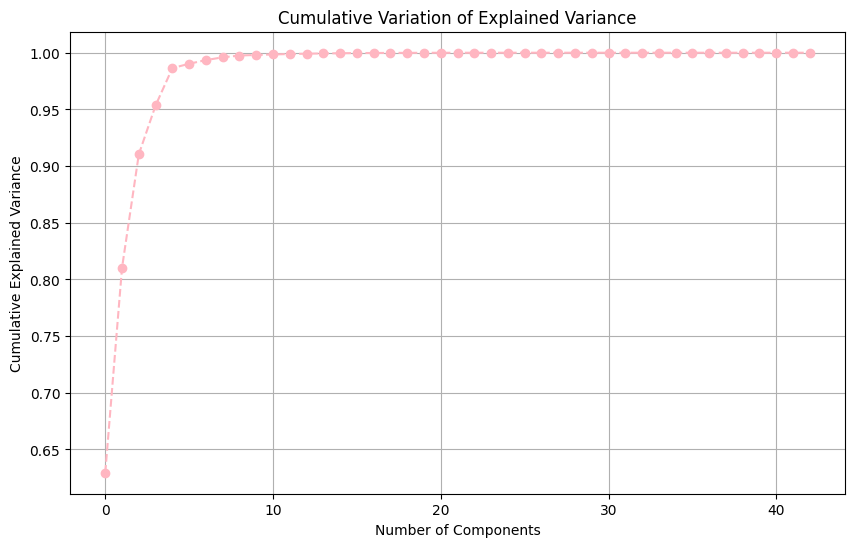

In [25]:
def main():
    data = FeedbackHHC(r'HH_Provider_Oct2023.csv')

    data.preprocess_data()
    
    data.data.to_csv('preprocessed_data.csv', index=False)
        
    # data.exploratory_analysis()
    data.select_attributes_pca()
    
    # preprocessed_data = FeedbackHHC('preprocessed_data.csv')
    # 
    # 
    # preprocessed_data.train_random_forest_regressor()
    # preprocessed_data.train_random_forest_classifier()
    # preprocessed_data.train_random_forest_classifier_multiclass()
    # 
    # preprocessed_data.train_neural_network()
    # preprocessed_data.train_neural_network1()
    # preprocessed_data.train_neural_network_classifier()
    # 
    # preprocessed_data.train_svm_classifier()
    # preprocessed_data.train_svm_classifier_multiclass()
    # 
    # preprocessed_data.train_decision_tree_regressor()
    # preprocessed_data.train_decision_tree_classifier()
    # preprocessed_data.train_decision_tree_classifier_multiclass()
    # 
    # preprocessed_data.compare_models_performance()
    # preprocessed_data.compare_models_performance_multiclass()


if __name__ == "__main__":
    main()